In [45]:
import glob
import numpy as np
import scipy as sp
import einops as eo
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation


M0 = 1400 #mT
shape = [3*25.4/16, 25.4/8] #radius and height
x0 = np.array([0,0,10, 0,0,1])


In [46]:
def B_dipole(position, rotation, M0, shape):
    R = np.sqrt(np.sum(position**2, axis=1))
    B = (M0 * (shape[0]) ** 2 * shape[1] / (16)) * (
        (
            3
            * position
            / R[:, np.newaxis] ** 5
            * (eo.einsum(position, rotation, "sensor dim,  dim -> sensor"))[
                :, np.newaxis
            ]
        )
        - rotation[np.newaxis, :] / (R[:, np.newaxis] ** 3)
    )
    return B


def getField_dipole(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def getField_dipole_fixed(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def cost_dipole(x, B, positions, M0, shape):
    diff = getField_dipole(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)


def minimize(x0, B, positions, M0, shape, *args):
    #print("Starting mimimization")
    b_args = (B, positions, M0, shape)
    cons = [{"type": "eq", "fun": lambda x: x[3] ** 2 + x[4] ** 2 + x[5] ** 2 - 1}]
    bounds = [(-100, 100), (-100, 100), (0, 100), (-1, 1), (-1, 1), (-1, 1)]
    res = sp.optimize.minimize(
        fun=cost_dipole, x0=x0, args=b_args, tol=1e-100, constraints=cons, bounds=bounds, *args
    ).x  
    #print(f"Finished mimimization with shape {b_args[3]} at {res}")
    return res

def circle_radius(x1, y1, x2, y2, x3, y3):
    # Calculate lengths of sides of the triangle formed by the three points
    a = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    b = math.sqrt((x3 - x2) ** 2 + (y3 - y2) ** 2)
    c = math.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)

    # Calculate the semi-perimeter of the triangle
    s = (a + b + c) / 2

    # Calculate the area of the triangle using Heron's formula
    area = math.sqrt(s * (s - a) * (s - b) * (s - c))

    # Calculate the radius of the circle using the formula: radius = (abc) / (4 * area)
    radius = (a * b * c) / (4 * area)
    
    return radius

def comparison_plot(locact, locpred, axis, relative):

    if axis == 'x':
        ax = 0
    elif axis == 'y':
        ax = 1
    else:
        ax = 2

    index = list(range(len(locact[:,ax])))
    act = locact[:, ax]
    pred = locpred[:, ax]

    rel = ''

    if relative==True:
        act = [x - locact[0, ax] for x in locact[:, ax]]
        pred = [x - locpred[0, ax] for x in locpred[:, ax]]
        rel = ' (Relative)'

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(index, pred, label='Predicted' + rel)
    plt.scatter(index, act, label='Actual' + rel)
    plt.xlabel('Index')
    plt.ylabel(axis + '-component')
    plt.title('Comparison of '+axis+ ' Location' + rel+ ': Predicted vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

def comp_plot3D(locact, locpred, xact, yact, axis, relative):

    if axis == 'x':
        ax = 0
    elif axis == 'y':
        ax = 1
    else:
        ax = 2

    index = list(range(len(locact[:,ax])))
    act = locact[:, ax]
    pred = locpred[:, ax]

    rel = ''

    if relative==True:
        act = [x - locact[0, ax] for x in locact[:, ax]]
        pred = [x - locpred[0, ax] for x in locpred[:, ax]]
        rel = ' (Relative)'

    fig = go.Figure(data=[
        go.Scatter3d(x=xact, y=yact, z=pred, name='Predicted' + rel),
        go.Scatter3d(x=xact, y=yact, z=act, name='Actual' + rel)])
    fig.show()

    return

def displacement_plot(actual, predicted):

    dispx = np.array(predicted[:,0]-predicted[:,0][0])
    dispy = np.array(predicted[:,1]-predicted[:,1][0])
    dispz = np.array(predicted[:,2]-predicted[:,2][0])
    disp = np.sqrt(dispx**2+dispy**2+dispz**2)
    actdispx = np.array(actual[:,0]-actual[:,0][0])
    actdispy = np.array(actual[:,1]-actual[:,1][0])
    actdispz = np.array(actual[:,2]-actual[:,2][0])
    actdisp = np.sqrt(actdispx**2+actdispy**2+actdispz**2)

    plt.figure(figsize=(8, 6))
    plt.scatter(list(range(len(disp))), disp, label='Predicted Displacement')
    plt.scatter(list(range(len(actdisp))), actdisp, label='Actual Displacement')
    plt.xlabel('Index')
    plt.ylabel('Displacement (mm)')
    plt.title('Magnet Displacement')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

def importfitting(folder):

    file_list = sorted(glob.glob(f'{folder}/*.npz'))
    len(file_list)
    data = np.load(file_list[0])
    pos = data['pos'][0]

    locpred = [np.array([0,0,0])]
    anglepred = [np.array([0,0,0])]
    Bstdev = [np.array(pos)]
    for x in range(len(file_list)):
        data = np.load(file_list[x])
        mags = data['mags']
        pos = data['pos'][0]
        B = np.mean(mags, axis=0)
        mags_stdev = np.std(mags, axis=0)
        x_res = minimize(x0, B, pos, M0, shape)
        locpred = np.append(locpred, [x_res[0:3]], axis=0)
        anglepred = np.append(anglepred, [x_res[3:6]], axis=0)
        Bstdev = np.append(Bstdev, [mags_stdev], axis=0)
    locpred = np.delete(locpred, 0, axis=0)
    anglepred = np.delete(anglepred, 0, axis=0)
    Bstdev = np.delete(Bstdev, 0 ,axis=0)

    return locpred, anglepred, Bstdev

def actualangle(xind, yind, xscal, xcon, yscal, ycon, isoff):

    angact = [np.array([0, 0, 0])]
    for y in range(yind):
        for x in range(xind):
            R = Rotation.from_euler('ZYX' ,np.array([0, yscal*y-ycon, xscal*x-xcon]), degrees=True)
            norm = np.array([[0, 0, 1]])
            rotated = R.apply(norm, inverse=False)[0]
            #add = np.array([np.sin(np.deg2rad(2*y-4)), -np.sin(np.deg2rad(2*x-4)), np.cos(np.deg2rad(2*y-4))*np.cos(np.deg2rad(2*x-4))])
            angact = np.append(angact, [rotated], axis=0)
    angact = np.delete(angact, 0, axis=0)
    locact = angact*isoff

    return angact, locact

In [47]:
folder = r"C:\Users\Brandon Nguyen\Documents\Github\magnetic-sensor-data\MLX06062024_10mmAboveIsocenter_Z15mm"
locpred, anglepred, Bstdev = importfitting(folder)
np.append(locpred, anglepred, axis=1)

array([[ 3.78912728e-01, -3.17410949e-01,  1.74441183e+01,
        -1.52799391e-01,  1.70127809e-01,  9.73503403e-01],
       [ 3.85958333e-01,  1.00933783e-01,  1.74303647e+01,
        -1.52186666e-01,  1.45436142e-01,  9.77592731e-01],
       [ 3.70112985e-01,  5.16486956e-01,  1.74364577e+01,
        -1.52022239e-01,  1.24972923e-01,  9.80444291e-01],
       [ 3.62392958e-01,  9.53316935e-01,  1.74563751e+01,
        -1.51295537e-01,  1.00053709e-01,  9.83411875e-01],
       [ 3.48896259e-01,  1.36041931e+00,  1.74891014e+01,
        -1.50886147e-01,  7.43517984e-02,  9.85751074e-01],
       [-1.64337641e-03, -3.24433287e-01,  1.74515195e+01,
        -1.28958891e-01,  1.71232627e-01,  9.76754315e-01],
       [-1.96359703e-02,  1.13244842e-01,  1.74393086e+01,
        -1.29640621e-01,  1.45885874e-01,  9.80770422e-01],
       [-2.25193911e-02,  5.01784447e-01,  1.74425065e+01,
        -1.27888827e-01,  1.24812950e-01,  9.83903540e-01],
       [-4.53883648e-02,  9.11985643e-01,  1.746

In [48]:
actang = [np.array([0, 0, 0])]
xact = [np.array([0])]
yact = [np.array([0])]
for y in range(5):
    for x in range(5):
        R = Rotation.from_euler('ZYX' ,np.array([0, 2*y-4, 2*x-4]), degrees=True)
        norm = np.array([[0, 0, 1]])
        rotated = R.apply(norm, inverse=False)[0]
        #add = np.array([np.sin(np.deg2rad(2*y-4)), -np.sin(np.deg2rad(2*x-4)), np.cos(np.deg2rad(2*y-4))*np.cos(np.deg2rad(2*x-4))])
        actang = np.append(actang, [rotated], axis=0)
        xact = np.append(xact, [2*y-4])
        yact = np.append(yact, [2*x-4])
actang = np.delete(actang, 0, axis=0)
xact = np.delete(xact, 0, axis=0)
yact = np.delete(yact, 0, axis=0)
locact = actang*12
np.sum(actang**2)
print(actang)
print(xact)
print(yact)

[[-0.06958655  0.06975647  0.99513403]
 [-0.06971398  0.0348995   0.99695636]
 [-0.06975647  0.          0.99756405]
 [-0.06971398 -0.0348995   0.99695636]
 [-0.06958655 -0.06975647  0.99513403]
 [-0.03481448  0.06975647  0.99695636]
 [-0.03487824  0.0348995   0.99878203]
 [-0.0348995   0.          0.99939083]
 [-0.03487824 -0.0348995   0.99878203]
 [-0.03481448 -0.06975647  0.99695636]
 [ 0.          0.06975647  0.99756405]
 [ 0.          0.0348995   0.99939083]
 [ 0.          0.          1.        ]
 [ 0.         -0.0348995   0.99939083]
 [ 0.         -0.06975647  0.99756405]
 [ 0.03481448  0.06975647  0.99695636]
 [ 0.03487824  0.0348995   0.99878203]
 [ 0.0348995   0.          0.99939083]
 [ 0.03487824 -0.0348995   0.99878203]
 [ 0.03481448 -0.06975647  0.99695636]
 [ 0.06958655  0.06975647  0.99513403]
 [ 0.06971398  0.0348995   0.99695636]
 [ 0.06975647  0.          0.99756405]
 [ 0.06971398 -0.0348995   0.99695636]
 [ 0.06958655 -0.06975647  0.99513403]]
[-4 -4 -4 -4 -4 -2 -2 -2

Try cylindrical formula instead of dipole. 
Figure out how to calibrate rotation stage setup. (Rotate about z-axis,...)
Calculate closest of magnet to sensors - for scaling
Plot angles for comparison
Go from [4,4] to [-4,-4]
Spherical magnets???

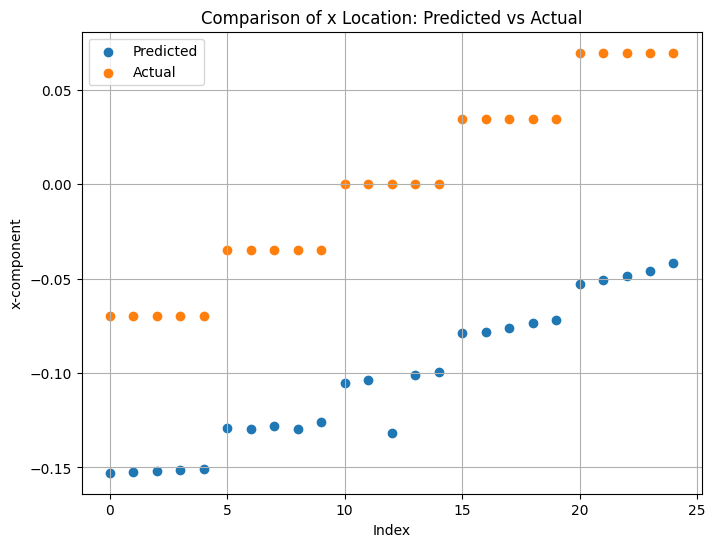

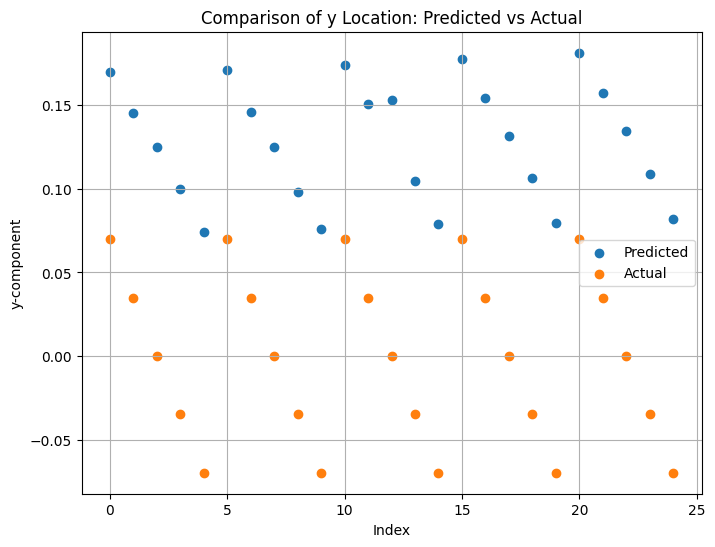

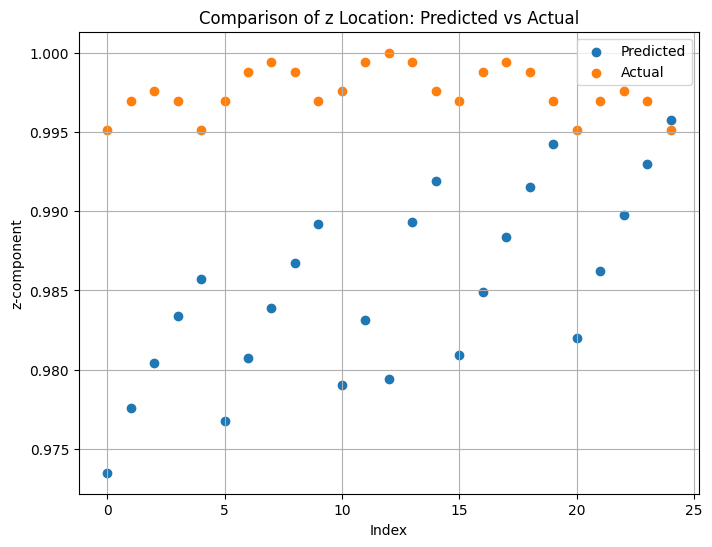

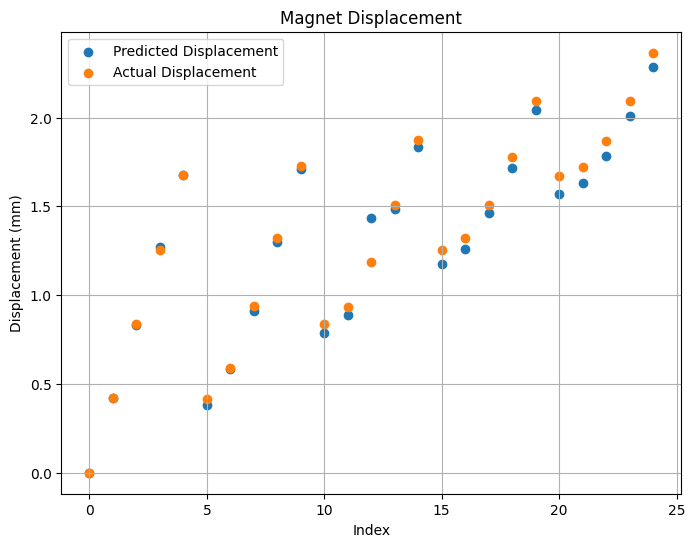

In [49]:
comparison_plot(actang, anglepred, axis='x', relative=False)
comparison_plot(actang, anglepred, axis='y', relative=False)
comparison_plot(actang, anglepred, axis='z', relative=False)
displacement_plot(locact, locpred)

In [50]:
comp_plot3D(actang, anglepred, xact, yact, axis='x', relative=False)
comp_plot3D(actang, anglepred, xact, yact, axis='y', relative=False)
comp_plot3D(actang, anglepred, xact, yact, axis='z', relative=False)

In [51]:
fig = go.Figure(data=go.Cone(x=locpred[:,0], y=locpred[:,1], z=locpred[:,2], u=anglepred[:,0], v=anglepred[:,1], w=anglepred[:,2], 
                             sizemode="absolute", sizeref=2))

fig.update_layout(scene_camera_eye=dict(x=-0.76, y=1.8, z=0.92))

fig.show()